In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
from numpy.linalg import inv
np.set_printoptions(precision=16)
from Imaging_core_new import *
from Gridding_core import *

### 1. Read in the data

In [2]:
#########  Read in visibilities ##########
data = np.genfromtxt('simul3d.csv', delimiter = ',')
jj = complex(0,1)
u_original = data.T[2][1:]
v_original = data.T[3][1:]
w_original = data.T[4][1:]
V_original = data.T[5][1:] + jj*data.T[6][1:]
n_uv = len(u_original)
uv_max = max(np.sqrt(u_original**2+v_original**2))
V,u,v,w = Visibility_minusw(V_original,u_original,v_original,w_original)

#### Determine the pixel size ####
X_size = 300 # image size on x-axis
Y_size = 300 # image size on y-axis
X_min = -1.15/2 #You can change X_min and X_max in order to change the pixel size.
X_max = 1.15/2
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -1.15/2 #You can change Y_min and Y_max in order to change the pixel size.
Y_max = 1.15/2
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  790.681757280536  arcsec


### 2. determine the number of w planes 

In [16]:
W = 7
x0 = 0.25 # only retain the central half of the image
Nw_2R, w_values, dw = Wplanes(W, X_max, Y_max, w, x0)

We will have 77 w-planes


### 3. Improved w-stacking method

### 3.1 3D Gridding


In [17]:
from scipy.special import pro_ang1

## Spheroidal function C(u)
def C(u):
    if np.abs(u) == W/2:
        return 1e-25
    else:
        return (1-(2*u/W)**2)**0.5 * pro_ang1(1, 1, W/2*np.pi, 2*u/W)[0]

In [18]:
Nfft = 600
im_size = 600
ind = find_nearestw(w_values, w)

#### Gridding on w-axis

In [19]:
V_wgrid, u_wgrid, v_wgrid, beam_wgrid = grid_w_other(V, u, v, w, w_values, W, Nw_2R, ind, dw, C)

Elapsed time during the w-gridding calculation in seconds: 1.718765999999988


#### Gridding on uv-axis

In [20]:
I_size = int(im_size*2*x0)
I_image = np.zeros((I_size,I_size),dtype = np.complex_)
B_image = np.zeros((I_size,I_size),dtype = np.complex_)

t2_start = process_time() 
for w_ind in range(Nw_2R):
    print ('This is the ', w_ind, 'th level facet out of ',Nw_2R,' w facets.\n')
    V_update = np.asarray(V_wgrid[w_ind])
    u_update = np.asarray(u_wgrid[w_ind])
    v_update = np.asarray(v_wgrid[w_ind])
    beam_update = np.asarray(beam_wgrid[w_ind])
    V_grid, B_grid = grid_uv_other(V_update, u_update, v_update, beam_update, W, im_size, X_max, X_min, Y_max, Y_min, C)
    I_image += FFTnPShift(V_grid, w_values[w_ind], X, Y, im_size, x0)
    B_image += FFTnPShift(B_grid, w_values[w_ind], X, Y, im_size, x0)
    B_grid = np.zeros((im_size,im_size),dtype = np.complex_) 
    V_grid = np.zeros((im_size,im_size),dtype = np.complex_)
t2_stop = process_time()   
print("Elapsed time during the uv-gridding calculation in seconds:", t2_stop-t2_start)  

This is the  0 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  1 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  2 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  3 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  4 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  5 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  6 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  7 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  8 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
This is the  9 th level facet out of 

This is the  76 th level facet out of  77  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Elapsed time during the uv-gridding calculation in seconds: 227.69295699999998


#### Rescale and have a look

<IPython.core.display.Javascript object>


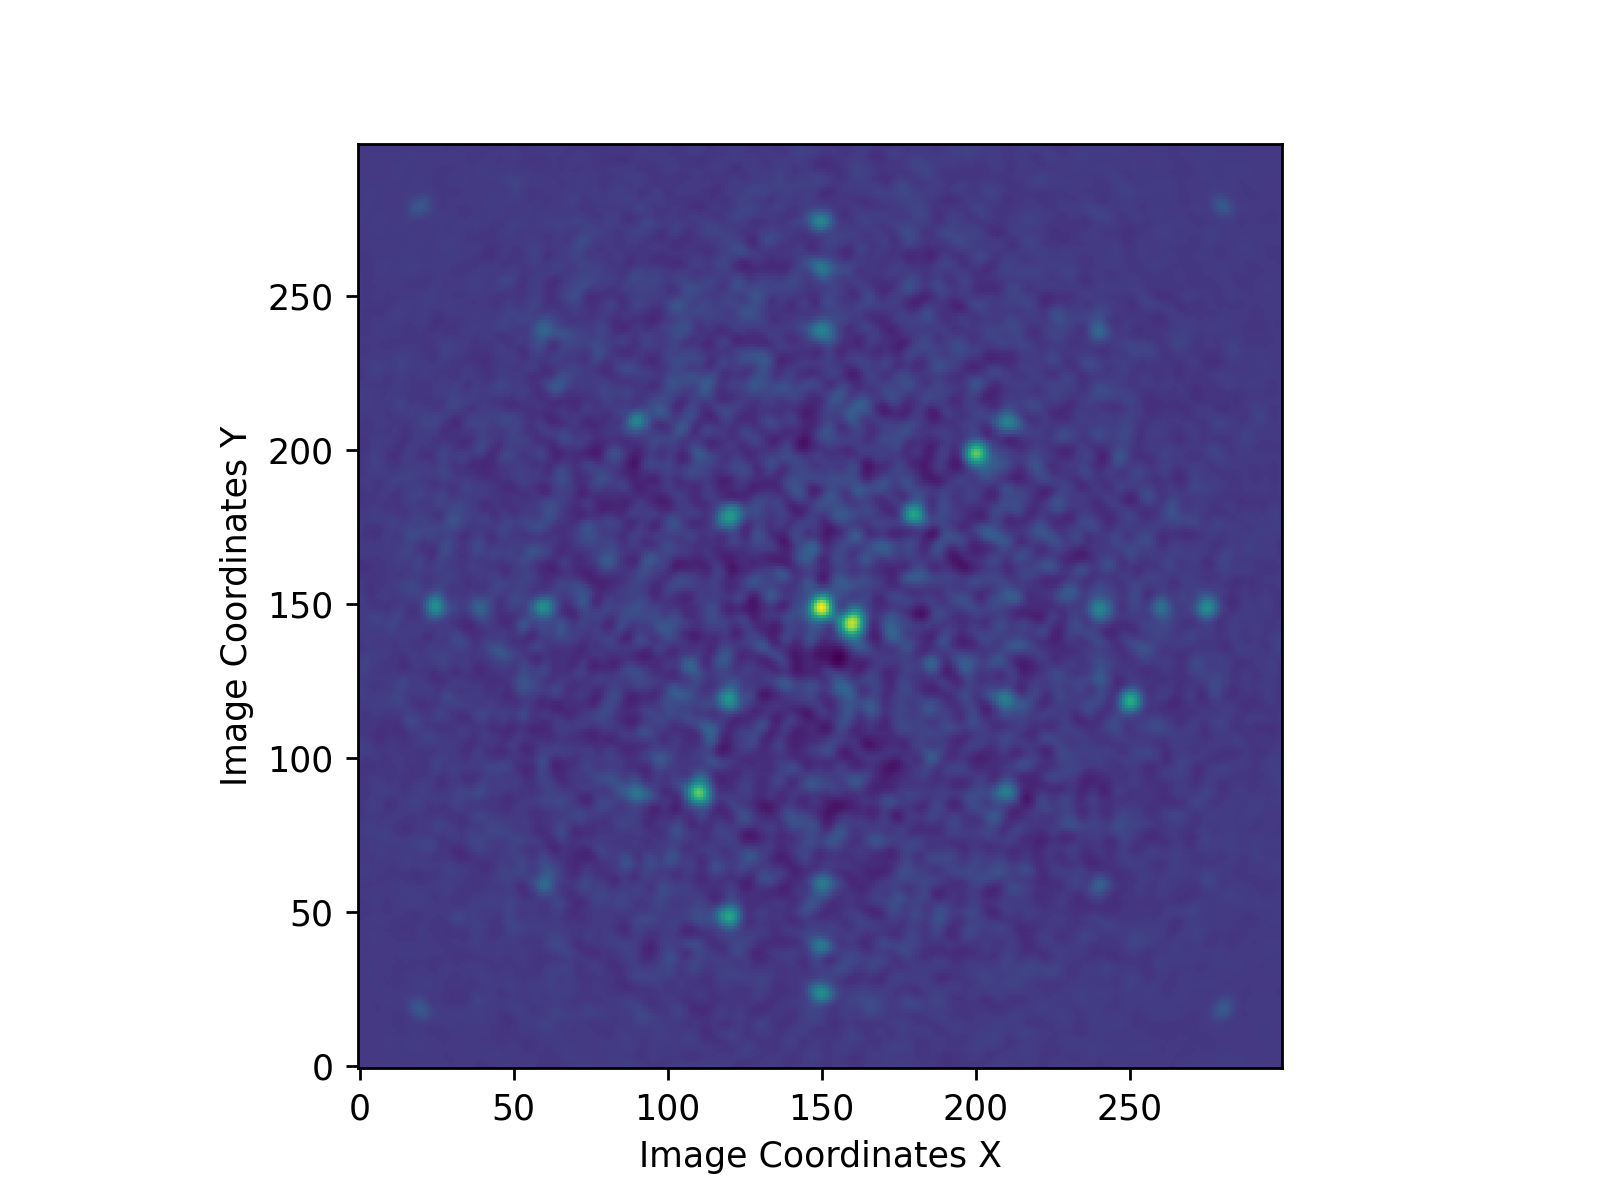

(15.989992960054554+0j)

In [21]:
I_image_now = image_rescale(I_image,im_size, n_uv)
B_image_now = image_rescale(B_image,im_size, n_uv)
plt.figure()
plt.imshow(np.rot90(I_image_now.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()
B_image_now[150,150]

#### Correcting functions h(x)h(y)

#### W= 7, x0 = 0.25

In [22]:
Nfft = 600
# Use these for calculating gridding correction on the FFT grid
M = 32
I_xycorrected = xy_correct_other(I_image_now, im_size, W, C, x0=0.25)
B_xycorrected = xy_correct_other(B_image_now, im_size, W, C, x0=0.25)
#need to change the gridding function 'gridder' inside xy_correct_other

#### Correcting function on z axis

In [23]:
Cor_gridz = z_correct_cal_other(X_min, X_max, Y_min, Y_max, dw, im_size, W, C, x0=0.25)
I_zcorrected = z_correct(I_xycorrected, Cor_gridz, im_size, x0=0.25)
B_zcorrected = z_correct(B_xycorrected, Cor_gridz, im_size, x0=0.25)

### 4 DFT and FFT dirty image difference

<IPython.core.display.Javascript object>


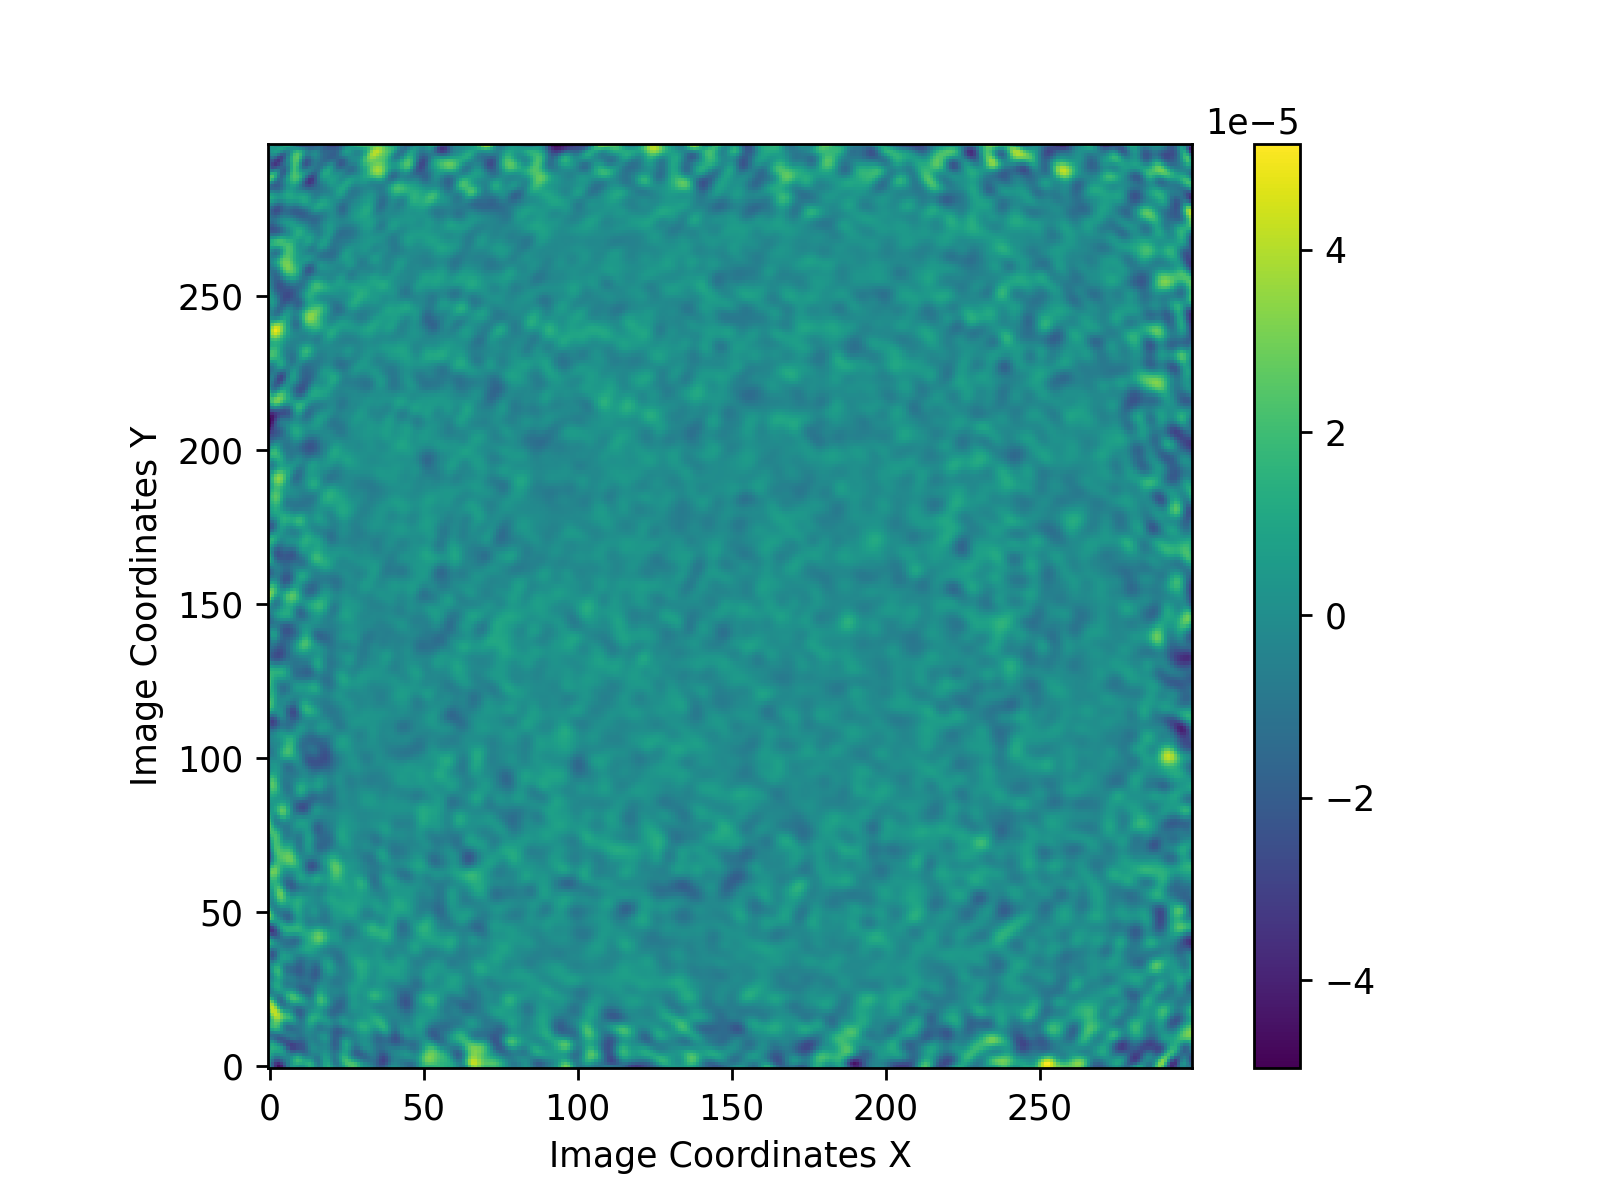

In [24]:
I_DFT = np.loadtxt('I_DFT_simul300.csv', delimiter = ',')
I_dif = I_DFT - I_zcorrected.real
plt.figure()
plt.imshow(np.rot90(I_dif,1), origin = 'lower')
plt.colorbar()
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.show()

In [26]:
rms = RMS(I_dif, im_size, 0.5, x0=0.25)
print (rms)

5.426818905922932e-06
